<a href="https://colab.research.google.com/github/lankutse/Game-Genre-Recognition/blob/main/game_genre_recognition_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

In [2]:
#importing necessary classes and modules
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Dense, Flatten, Reshape, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
import pandas as pd
import matplotlib.pyplot as plt

import kagglehub
#getting our dataset from kaggle
path = kagglehub.dataset_download("gsimonx37/backloggd")
print("Path to dataset files:", path)


# Use the path from the kagglehub.dataset_download output
base_path = path # path is the variable from the previous cell
#loading the genres and the games
genres = pd.read_csv(f"{base_path}/genres.csv")
games = pd.read_csv(f"{base_path}/games.csv")

Path to dataset files: /kaggle/input/backloggd


In [3]:
#getting our top 10 genres that we will use in training/testing our model
genre_counts = (
    genres["genre"]
    .value_counts()
    .reset_index(name="count")
    .rename(columns={"index": "genre"})
)

print(genre_counts.head(10))


       genre  count
0      Indie  58720
1  Adventure  55918
2  Simulator  26254
3        RPG  25019
4   Strategy  24493
5    Shooter  20062
6     Puzzle  19568
7     Arcade  16696
8   Platform  15287
9      Sport  11343


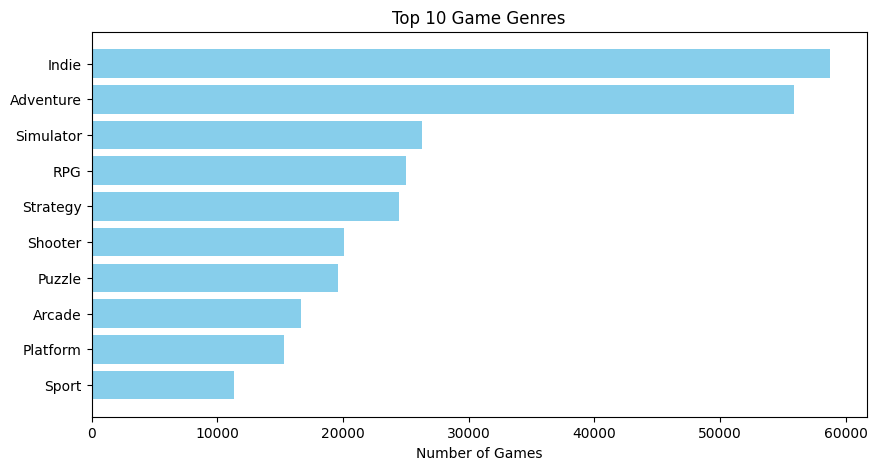

In [4]:
#graph to visualize the data printed above (how many games are in each genre)
top_10 = genre_counts.head(10)

plt.figure(figsize=(10,5))
plt.barh(top_10["genre"], top_10["count"], color="skyblue")
plt.xlabel("Number of Games")
plt.title("Top 10 Game Genres")
plt.gca().invert_yaxis()
plt.show()


In [5]:
#merging the genre data with the games data so we can get games per year by genre
genres_games = genres.merge(
    games,
    left_on="id",
    right_on="id",
    suffixes=('_genre', '_game')
)
genres_games["date"] = pd.to_datetime(
    genres_games["date"],
    errors='coerce'
)

#dropping any missing dates
genres_games = genres_games.dropna(subset=["date"])

#extracting the year from our merged datasets
genres_games["year"] = genres_games["date"].dt.year

#printing the amount of games per year per genre
year_genre_counts = (
    genres_games
    .groupby(["year", "genre"])
    .size()
    .reset_index(name="count")
)

print(year_genre_counts.head())


   year            genre  count
0  1947  Point-and-Click      1
1  1950           Puzzle      1
2  1950         Tactical      1
3  1951          Pinball      1
4  1951         Strategy      1


/tmp/ipython-input-5-2972995802.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres_games["year"] = genres_games["date"].dt.year


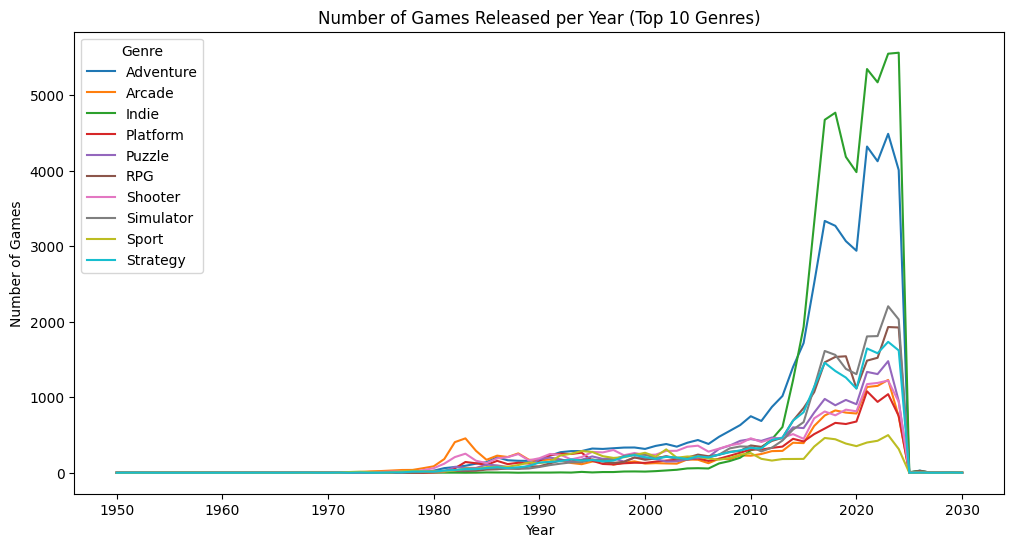

In [6]:
#graphing the number of games released per year, separated into the top 10 genres
top_genres = genre_counts.head(10)["genre"].tolist()
filtered = year_genre_counts[year_genre_counts["genre"].isin(top_genres)]
pivoted = filtered.pivot(
    index="year",
    columns="genre",
    values="count"
).fillna(0)
pivoted.plot(figsize=(12,6))
plt.title("Number of Games Released per Year (Top 10 Genres)")
plt.ylabel("Number of Games")
plt.xlabel("Year")
plt.legend(title="Genre")
plt.show()


In [7]:
genres_games.drop(['rating', 'reviews', 'plays', 'playing', 'backlogs', 'date', 'wishlists', 'description'], axis=1, inplace=True)
print(genres_games.head())

        id            genre                               name  year
0  1000001  Point-and-Click  Cathode Ray Tube Amusement Device  1947
1  1000002           Puzzle                   Bertie the Brain  1950
2  1000002         Tactical                   Bertie the Brain  1950
3  1000003          Pinball                                Nim  1951
4  1000003         Strategy                                Nim  1951


In [8]:
#narrowing our data down to only games from 2015 to 2025
games_filtered = genres_games[genres_games["year"] >= 2015].copy()

top_genre = (
    games_filtered["genre"]
    .value_counts()
    .head(10)
    .index
    .tolist()
)
games_filtered = games_filtered[
    games_filtered["genre"].isin(top_genre)
].copy()

#shape = (number of games in dataset, parameters [id, genre, name, year])
print(games_filtered.shape)
print(games_filtered.head())
print("Number of games from 2015-2025 that are part of the top 10 genres: ")
print(len(games_filtered))

(162508, 4)
            id         genre  \
12714  1010260        Arcade   
12715  1010260       Shooter   
62104  1047763     Adventure   
62106  1047763        Puzzle   
62107  1047763  Visual Novel   

                                                    name  year  
12714                                             Gynoug  2021  
12715                                             Gynoug  2021  
62104  Phoenix Wright: Ace Attorney - The Contempt of...  2017  
62106  Phoenix Wright: Ace Attorney - The Contempt of...  2017  
62107  Phoenix Wright: Ace Attorney - The Contempt of...  2017  
Number of games from 2015-2025 that are part of the top 10 genres: 
162508


In [9]:
#balancing our dataset by getting 100 games per genre per year, for 1,000 games per year and 10,000  games total
#the actual shape of the data is 10,135, because if some groups by genre/year had less than 100 games all of them were included.
sampled_games = games_filtered.groupby(['genre', 'year']).apply(
    lambda x: x.sample(n=100, replace=False) if len(x) >= 100 else x
).reset_index(drop=True)

print(sampled_games.shape)
print(sampled_games.head())

(10135, 4)
        id      genre                                   name  year
0  1069770  Adventure                              Timeframe  2015
1  1070224  Adventure                              Kidnapped  2015
2  1070631  Adventure                               I.S.I.S.  2015
3  1071317  Adventure                        Outbreak Escape  2015
4  1068441  Adventure  Selfie : Sisters of the Amniotic Lens  2015


/tmp/ipython-input-9-1491164412.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_games = games_filtered.groupby(['genre', 'year']).apply(


In [10]:
import os
from sklearn.preprocessing import LabelEncoder

# Get poster image filenames and IDs
poster_dir = os.path.join(path, "posters")
poster_files = os.listdir(poster_dir)

# Extract valid numeric poster IDs from filenames
poster_ids = [
    int(f.replace(".jpg", ""))
    for f in poster_files
    if f.endswith(".jpg") and f.replace(".jpg", "").isdigit()
]
available_ids = set(poster_ids)

print(f"{len(available_ids)} poster images available.")

# Encode genre strings into integer labels
le = LabelEncoder()
sampled_games["label"] = le.fit_transform(sampled_games["genre"])
print(sampled_games[["genre", "label"]].drop_duplicates())

179846 poster images available.
             genre  label
0        Adventure      0
1037        Arcade      1
2038         Indie      2
3078      Platform      3
4083        Puzzle      4
5085           RPG      5
6115       Shooter      6
7118     Simulator      7
8125      Strategy      8
9129  Visual Novel      9


In [11]:
#creating a multi-hot encoding vector so that each videogame/poster can correspond to multiple genres
#ex - if a game was in both the adventure (label 0) and shooter (label 6) genres, its vector would be:
# [1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
def to_multihot(label_list, num_classes):
    vec = np.zeros(num_classes)
    vec[label_list] = 1
    return vec

In [12]:
#MATCHING POSTERS AND GENRE IMAGES

#keeping only games/genres with matching poster id's (not all of the games in our dataset had posters)
genres_with_images = sampled_games[
    sampled_games["id"].isin(available_ids)
].copy()

#get the genre(s) for each game into a list, put into the "labels" column
#ex - if a game has both is both action and shooter its label will be [0, 6]
genre_lists = genres_with_images.groupby("id")["label"].apply(list).reset_index()
genre_lists.rename(columns={"label": "labels"}, inplace=True)

#removing duplicate game entries because we have now combined their labels
metadata = genres_with_images.drop_duplicates("id")

#merging our data back together so that we have only 1 entry for each game that has a poster image
#and its corresponding genre labels
genres_with_images = metadata.merge(genre_lists, on="id")
genres_with_images.drop(['genre', 'label'], axis=1, inplace=True)

#print our complete data!
print("First 10 rows of genres_with_images:")
print(genres_with_images.head(10))
print(f"{genres_with_images.shape[0]} games with matching images.")

First 10 rows of genres_with_images:
        id                                               name  year  labels
0  1069770                                          Timeframe  2015     [0]
1  1070224                                          Kidnapped  2015     [0]
2  1070631                                           I.S.I.S.  2015     [0]
3  1068441              Selfie : Sisters of the Amniotic Lens  2015     [0]
4  1071022                                 Romero's Aftermath  2015     [0]
5  1070667  The Legend of Zelda: A Link to the Past Random...  2015  [0, 5]
6  1069652                                     The Last Dogma  2015     [0]
7  1070302                            Sonic Dreams Collection  2015     [0]
8  1068950                            An Assassin in Orlandes  2015     [0]
9  1067723                                               A.V.  2015     [0]
9033 games with matching images.


In [13]:
import contextlib
with open('output.txt', 'w') as f, contextlib.redirect_stdout(f):
    print(genres_with_images)

In [14]:
#splitting our data into training and testing
#this code DOES in fact shuffle the data, not all datapoints
#for one genre are in half of the data
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    genres_with_images,
    test_size=0.2,
    random_state=42
)
print(train_df.shape, test_df.shape)

(7226, 4) (1807, 4)


In [15]:
#because our model kept crashing if we tried to train it on all  videogames
#at once, we needed to separate it into pieces to train\test. 1/3
#9030 total datapoints!!
train_df_1 = train_df.head(2414)
test_df_1 = test_df.head(603)

In [16]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

IMG_SIZE = (224, 224)

def load_images(df, poster_dir, num_classes):
    X = []
    y = []

#loops through each game, gets its ID number and genre labels
    for _, row in df.iterrows():
        game_id = row["id"]
        label_list = row["labels"]
#converts the label list into a one hot encoding vector ([1, 6] -> [0, 1, 0, 0, 0, 0, 1, 0, 0, 0])
        multi_hot_label = np.zeros(num_classes)
        multi_hot_label[label_list] = 1

        image_path = os.path.join(poster_dir, f"{game_id}.jpg")

#loads the image and resizes it to 224, 224
#converts the image to a numpy array and normalizes pixel values to [0, 1].
        try:
            img = load_img(image_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0
            X.append(img_array)
            y.append(multi_hot_label)

        except Exception as e:
            print(f"Error loading {image_path}: {e}")

#returning:
  #the array of images (X) withshape: [number of samples, 224, 224, 3])
  #the array of multi-hot vectors (y) (shape: [number of samples, genres])
    return np.array(X), np.array(y)

In [17]:
X, y = load_images(train_df, poster_dir, 10) #10 is the number of genres

print("X shape:", X.shape)
print("number of datapoints, dimesions of image, dimensions of image, 3 channels (RGB)")
print("y shape:", y.shape)
print("number of datapoints, number of genres")


#each triplet ([0.01960784 0.01960784 0.01960784]) coresponds to a single pixel's RGB values
print("\nSample image array (X[0]):")
print(X[0])

print("\nSample label vector (y[0]):")
print(y[0])


X shape: (7226, 224, 224, 3)
number of datapoints, dimesions of image, dimensions of image, 3 channels (RGB)
y shape: (7226, 10)
number of datapoints, number of genres

Sample image array (X[0]):
[[[0.         0.28235295 0.25490198]
  [0.         0.28627452 0.25882354]
  [0.         0.28627452 0.25882354]
  ...
  [0.00784314 0.34117648 0.3137255 ]
  [0.00784314 0.34117648 0.3137255 ]
  [0.00784314 0.34117648 0.3137255 ]]

 [[0.         0.28627452 0.25882354]
  [0.         0.28627452 0.25882354]
  [0.         0.2901961  0.2627451 ]
  ...
  [0.00392157 0.34509805 0.3137255 ]
  [0.00392157 0.34509805 0.3137255 ]
  [0.00392157 0.34509805 0.3137255 ]]

 [[0.00392157 0.2901961  0.2627451 ]
  [0.00392157 0.2901961  0.2627451 ]
  [0.         0.2901961  0.2627451 ]
  ...
  [0.00392157 0.34509805 0.3137255 ]
  [0.00392157 0.34509805 0.3137255 ]
  [0.00392157 0.34509805 0.3137255 ]]

 ...

 [[0.         0.23529412 0.20784314]
  [0.         0.23529412 0.20784314]
  [0.         0.23529412 0.2078431

In [18]:
#preparing our training and testing data
num_classes = sampled_games['label'].max() + 1

X_train, y_train = load_images(train_df_1, poster_dir, num_classes=num_classes)
X_test, y_test = load_images(test_df_1, poster_dir, num_classes=num_classes)

#printing their shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2414, 224, 224, 3)
y_train shape: (2414, 10)
X_test shape: (603, 224, 224, 3)
y_test shape: (603, 10)


In [19]:
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from keras.layers import Input
from keras.models import Model
from keras.applications.efficientnet import EfficientNetB2
from keras.applications.densenet import DenseNet121
from keras.regularizers import l2

base_model = DenseNet121(include_top=False, input_shape=(224,224,3))

#freezing the model except for the last couple layers specified
unfreeze = 4
for layer in base_model.layers[:-unfreeze]:
    layer.trainable = False

#our model, using transfer learning with densenet121
model = keras.models.Sequential([
    base_model,
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  #0.001 is the penalty factor/regularization strength
    GlobalAveragePooling2D(),
    Dense(10, activation='sigmoid'),
])

#area under the curve - shows how well the model is guessing (if its around 50% - bad. close to 100? good!)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.BinaryAccuracy(name='bin_acc')])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7, 7, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169,994 (27.35 MB)

 Trainable params: 171,402 (669.54 KB)

 Non-trainable params: 6,998,592 (26.70 MB)

In [20]:
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stop])

#printing training results
print("Final training accuracy:", history.history['accuracy'][-1])
print("Final training loss:", history.history['loss'][-1])

Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 335s 10s/step - accuracy: 0.1116 - auc: 0.5143 - bin_acc: 0.8366 - loss: 0.6530 - val_accuracy: 0.1532 - val_auc: 0.5656 - val_bin_acc: 0.8915 - val_loss: 0.4931
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 337s 11s/step - accuracy: 0.2330 - auc: 0.6583 - bin_acc: 0.8960 - loss: 0.4445 - val_accuracy: 0.2050 - val_auc: 0.5948 - val_bin_acc: 0.8915 - val_loss: 0.4460
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 380s 11s/step - accuracy: 0.2874 - auc: 0.7188 - bin_acc: 0.8960 - loss: 0.4020 - val_accuracy: 0.1863 - val_auc: 0.6360 - val_bin_acc: 0.8928 - val_loss: 0.4211
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 384s 11s/step - accuracy: 0.3331 - auc: 0.7626 - bin_acc: 0.8983 - loss: 0.3734 - val_accuracy: 0.1801 - val_auc: 0.6192 - val_bin_acc: 0.8917 - val_loss: 0.4211
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 379s 11s/step - accuracy: 0.3653 - auc: 0.7942 - bin_acc: 0.9007 - loss: 0.3496 - val_accuracy: 0.2050 - val_auc: 0.6476 - val_bin_acc: 0.8930 - val_loss: 0.4003


In [21]:
total = 0
total_count = 0
for r in model.weights:
    r_array = r.numpy()
    total += np.sum(np.abs(r_array))
    total_count += r_array.size
print("Regularize weights average", total/total_count)

Regularize weights average 0.018419208


In [22]:
import numpy as np
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, classification_report

#assessing overall model performance
#setting threshold
threshold = 0.3

#predicting probablilities
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs >= threshold).astype(int)

#strict multi-label accuracy, model is only "correct" if it gets all the genres for a game right
strict_acc = accuracy_score(y_test, y_pred)

#hamming loss, evaluates miss classification by individual genre label
hamming = hamming_loss(y_test, y_pred)

# Macro and micro averaged F1 score
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')

# Classification report (per-label precision/recall/F1)
report = classification_report(y_test, y_pred)

# Print results
print("Strict multi-label accuracy (exact match):", strict_acc)
print("Hamming loss:", hamming)
print("F1 score (macro):", f1_macro)
print("F1 score (micro):", f1_micro)
#high precision means few false positives, high recall means few false negatives
print("\nClassification Report:\n", report)

19/19 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step
Strict multi-label accuracy (exact match): 0.08623548922056384
Hamming loss: 0.14129353233830846
F1 score (macro): 0.15363959200058483
F1 score (micro): 0.17120622568093385

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.24      0.24      0.24        78
           2       0.10      0.08      0.09        72
           3       0.17      0.15      0.16        55
           4       0.17      0.07      0.10        60
           5       0.10      0.05      0.07        62
           6       0.32      0.20      0.25        64
           7       0.15      0.13      0.14        67
           8       0.50      0.02      0.03        59
           9       0.57      0.39      0.46        64

   micro avg       0.23      0.14      0.17       641
   macro avg       0.23      0.13      0.15       641
weighted avg       0.23      0.14      0.16       641
 samp

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


19/19 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step


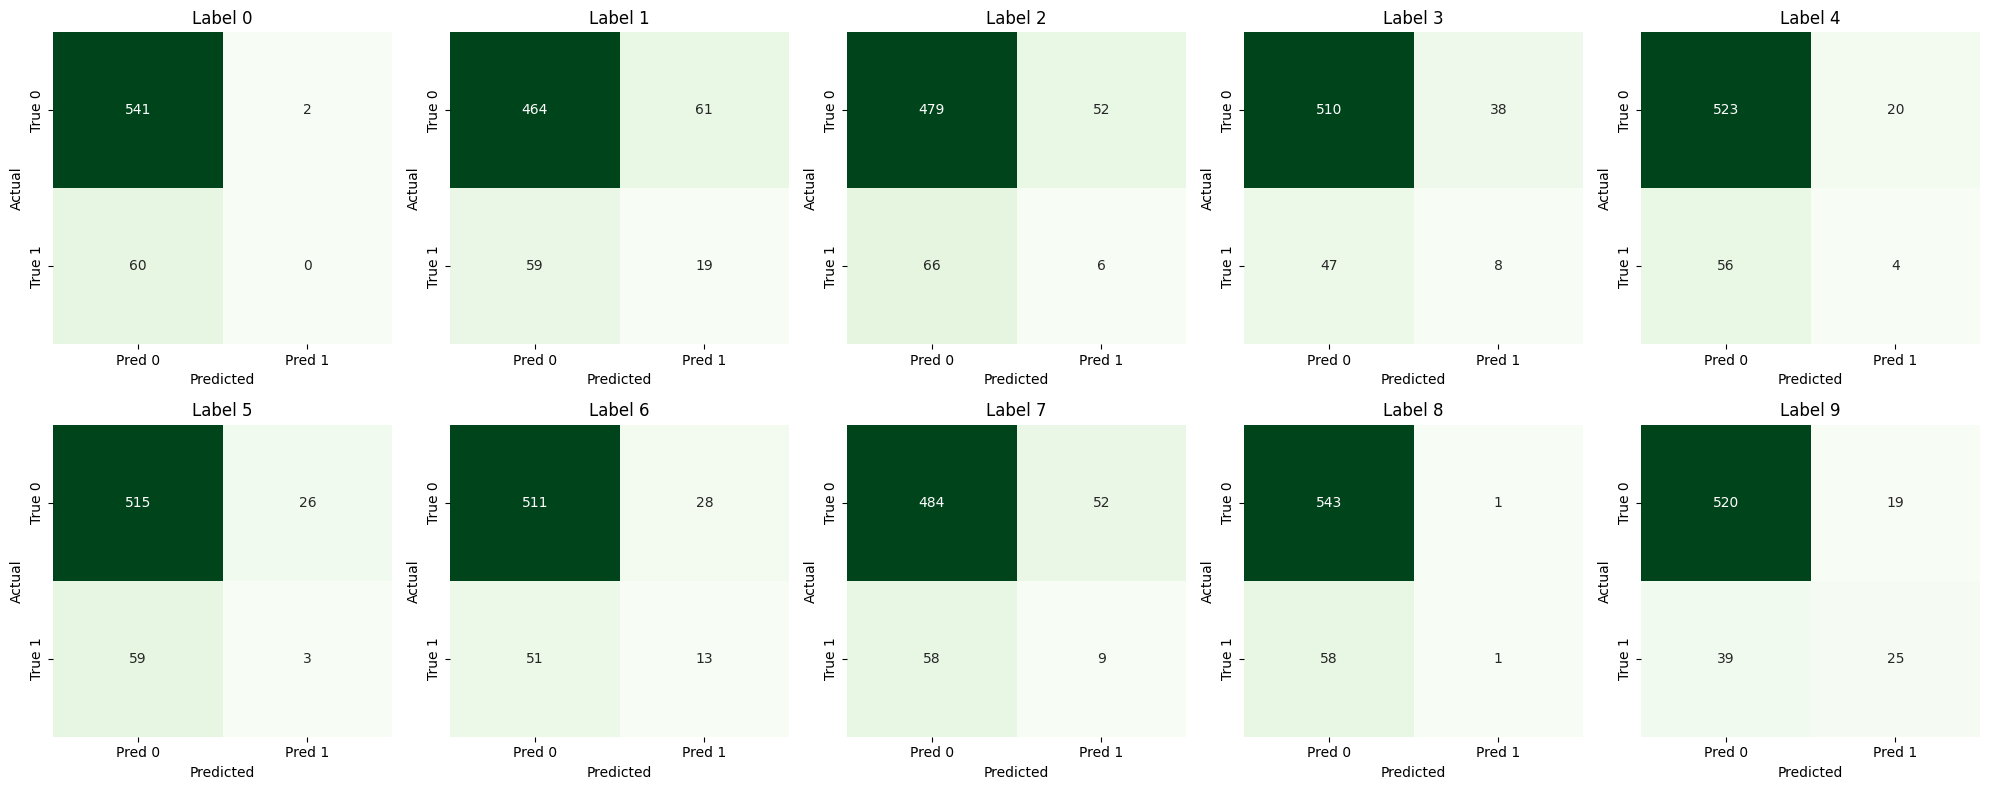

In [23]:
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Plotting individual confusion matricies for each genre

# Predict and binarize output
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs >= threshold).astype(int)

# Get confusion matrices
mlcm = multilabel_confusion_matrix(y_test, y_pred)
class_labels = [f"Label {i}" for i in range(mlcm.shape[0])]

# Set up 2x5 grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

for i, cm in enumerate(mlcm):
    row, col = divmod(i, 5)
    ax = axes[row, col]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"],
                ax=ax)

    ax.set_title(f"{class_labels[i]}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step


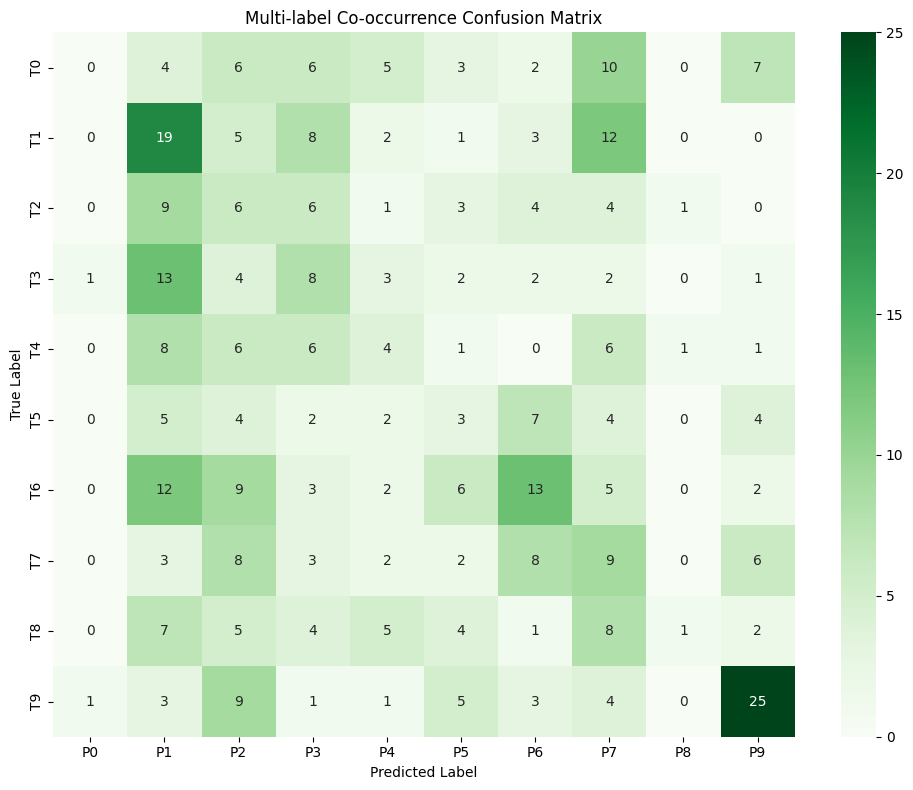

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
#Plotting the co-occurrence matrix
#Predict and binarize
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs >= threshold).astype(int)
#Generate a co-occurrence confusion matrix
#Each row is a true label vector, each column is a predicted label vector.
#This gives you a sense of how many labels were mispredicted together.

def multilabel_confusion_counts(y_true, y_pred):
    co_occurrence = np.zeros((y_true.shape[1], y_pred.shape[1]), dtype=int)
    for i in range(len(y_true)):
        true_indices = np.where(y_true[i] == 1)[0]
        pred_indices = np.where(y_pred[i] == 1)[0]
        for t in true_indices:
            for p in pred_indices:
                co_occurrence[t, p] += 1
    return co_occurrence

#Generate and plot the co-occurrence matrix
co_matrix = multilabel_confusion_counts(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=[f"P{i}" for i in range(10)], yticklabels=[f"T{i}" for i in range(10)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multi-label Co-occurrence Confusion Matrix")
plt.tight_layout()
plt.show()

In [25]:
print(train_df_1['labels'].value_counts())
print(test_df_1['labels'].value_counts())

labels
[0]          244
[5]          241
[9]          240
[4]          233
[1]          233
[3]          228
[7]          219
[6]          217
[8]          217
[2]          211
[7, 8]        10
[3, 4]         9
[0, 5]         7
[7, 9]         5
[0, 8]         5
[2, 5]         5
[0, 7]         5
[1, 3]         5
[6, 7]         4
[2, 8]         4
[0, 2]         4
[1, 6]         4
[0, 4]         4
[0, 6]         3
[4, 7]         3
[5, 8]         3
[4, 8]         3
[0, 1]         3
[2, 9]         3
[1, 4]         3
[5, 7]         3
[2, 5, 9]      2
[0, 3]         2
[0, 2, 5]      2
[3, 6]         2
[2, 7]         2
[3, 5]         2
[2, 3]         2
[1, 2]         2
[0, 2, 9]      1
[3, 7]         1
[1, 7]         1
[2, 4]         1
[1, 8]         1
[0, 6, 6]      1
[9, 9]         1
[2, 6]         1
[8, 9]         1
[6, 8]         1
[0, 2, 8]      1
[0, 9]         1
[1, 5]         1
[2, 5, 7]      1
[3, 3]         1
[4, 7, 8]      1
[0, 3, 5]      1
[0, 1, 3]      1
[4, 6, 8]      1
[0, 3, 

In [ ]:
#training the model with the second third of the data
train_df_2 = train_df.iloc[2414:4828]
test_df_2 = test_df.iloc[603:1206]
num_classes = sampled_games['label'].max() + 1
X_train, y_train = load_images(train_df_2, poster_dir, num_classes=num_classes)
X_test, y_test = load_images(test_df_2, poster_dir, num_classes=num_classes)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
history2 = model.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2)
print("Final training accuracy:", history2.history['accuracy'][-1])
print("Final training loss:", history2.history['loss'][-1])


In [ ]:
#assessing model performance 2/3
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs >= threshold).astype(int)
strict_acc = accuracy_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
report = classification_report(y_test, y_pred)
print("Strict multi-label accuracy (exact match):", strict_acc)
print("Hamming loss:", hamming)
print("F1 score (macro):", f1_macro)
print("F1 score (micro):", f1_micro)
print("\nClassification Report:\n", report)

In [ ]:
#multiple confusion matrices 2/3
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs >= threshold).astype(int)
mlcm = multilabel_confusion_matrix(y_test, y_pred)
class_labels = [f"Label {i}" for i in range(mlcm.shape[0])]
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for i, cm in enumerate(mlcm):
    row, col = divmod(i, 5)
    ax = axes[row, col]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"],
                ax=ax)

    ax.set_title(f"{class_labels[i]}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
#Plotting the co-occurrence matrix 2/3
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs >= threshold).astype(int)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(y_test.shape[1])]))
def multilabel_confusion_counts(y_true, y_pred):
    co_occurrence = np.zeros((y_true.shape[1], y_pred.shape[1]), dtype=int)
    for i in range(len(y_true)):
        true_indices = np.where(y_true[i] == 1)[0]
        pred_indices = np.where(y_pred[i] == 1)[0]
        for t in true_indices:
            for p in pred_indices:
                co_occurrence[t, p] += 1
    return co_occurrence
co_matrix = multilabel_confusion_counts(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=[f"P{i}" for i in range(10)], yticklabels=[f"T{i}" for i in range(10)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multi-label Co-occurrence Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
#training the model 3/3
train_df_2 = train_df.iloc[2414:4828]
test_df_2 = test_df.iloc[603:1206]
num_classes = sampled_games['label'].max() + 1
X_train, y_train = load_images(train_df_2, poster_dir, num_classes=num_classes)
X_test, y_test = load_images(test_df_2, poster_dir, num_classes=num_classes)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
history2 = model.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2)
print("Final training accuracy:", history2.history['accuracy'][-1])
print("Final training loss:", history2.history['loss'][-1])

In [ ]:
#assessing model performance 3/3
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs >= threshold).astype(int)
strict_acc = accuracy_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
report = classification_report(y_test, y_pred)
print("Strict multi-label accuracy (exact match):", strict_acc)
print("Hamming loss:", hamming)
print("F1 score (macro):", f1_macro)
print("F1 score (micro):", f1_micro)
print("\nClassification Report:\n", report)

In [ ]:
#multiple confusion matrices 3/3
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs >= threshold).astype(int)
mlcm = multilabel_confusion_matrix(y_test, y_pred)
class_labels = [f"Label {i}" for i in range(mlcm.shape[0])]
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for i, cm in enumerate(mlcm):
    row, col = divmod(i, 5)
    ax = axes[row, col]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"],
                ax=ax)

    ax.set_title(f"{class_labels[i]}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
#Plotting the co-occurrence matrix 3/3
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs >= threshold).astype(int)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(y_test.shape[1])]))
def multilabel_confusion_counts(y_true, y_pred):
    co_occurrence = np.zeros((y_true.shape[1], y_pred.shape[1]), dtype=int)
    for i in range(len(y_true)):
        true_indices = np.where(y_true[i] == 1)[0]
        pred_indices = np.where(y_pred[i] == 1)[0]
        for t in true_indices:
            for p in pred_indices:
                co_occurrence[t, p] += 1
    return co_occurrence
co_matrix = multilabel_confusion_counts(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=[f"P{i}" for i in range(10)], yticklabels=[f"T{i}" for i in range(10)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multi-label Co-occurrence Confusion Matrix")
plt.tight_layout()
plt.show()